El codigo presentado abajo es la implementacion del algoritmo 1 que se presenta en el paper de Wieghted Partial Sums.

--- Example 1: M_terms = 4, num_qubits = 3 ---


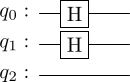

--- Example 2: M_terms = 13, num_qubits = 4 ---


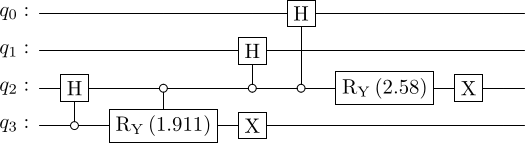

--- Example 3: M_terms = 42, num_qubits = 6 ---


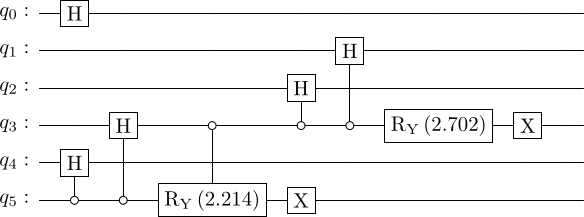

In [33]:
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister

# Function that computes the l_k terms from te decomposition of M
def decompose_M(M):
    binary_M = bin(M)[2:]
    l_vals = []
    for bit_position, bit_value in enumerate(reversed(binary_M)):
        if bit_value == '1':
            l_vals.append(bit_position)
    return sorted(l_vals)


def partial_sums(M, n_qubits):
    
    # Create a quantum register and a quantum circuit
    q_reg = QuantumRegister(n_qubits, name='q')
    quantum_circuit = QuantumCircuit(q_reg, name=f"Alg1_U_M{M}_n{n_qubits}")

    # Line 3 of Algorithm 1: if M_terms is a power of 2 (M = 2^r)
    if (M > 0) and ((M & (M - 1)) == 0):
        # M_terms is a power of 2.
        r = int(np.log2(M)) # r is the exponent, M_terms = 2^r.
        
        # Line 4: Apply Hadamard (H) gate on |q_i> for i=0 to r-1.
        # These are the r least significant qubits.
        for i in range(r):
            quantum_circuit.h(q_reg[i])
    else:
        # M_terms is not a power of 2 (Corresponds to lines 6-16 of Algorithm 1)
        
        # Decompose M into its binary representation
        l_values = decompose_M(M)
        # Index of the larget exponent in the decomposition
        k_idx = len(l_values) - 1

        # Precalculate the sum of power needed for the angle theta_m
        sum_powers = [0] * (k_idx + 1)
        acum_sum = 0
        for i in range(k_idx, -1, -1): # Iterate from k_idx down to 0
            acum_sum += (2**l_values[i])
            sum_powers[i] = acum_sum

        # Loop for m = k-1 down to 1
        for m in range(k_idx - 1, 0, -1):

            # Apply controlled Hadamard gates with the control state |0>.
            control = l_values[m + 1]
            for i in range(l_values[m + 1] - 1, l_values[m] - 1, -1):
                quantum_circuit.ch(q_reg[control], q_reg[i], ctrl_state='0')
            

            # Line 11: Apply controlled R_Y(Theta_m) gate.
            # Theta_m = 2 * arccos(sqrt(2^l_m / (M_terms - M_{m-1})))
            # (M_terms - M_{m-1}) is sum_powers_from_m_to_k_arr[m_loop_l_idx]
            # 2^l_m is 2**l_values[m_loop_l_idx]
            theta_m = 2 * np.arccos(np.sqrt((2**l_values[m] / sum_powers[m])))
            
            # Apply CR_Y(Theta_m) with the control state |0>..
            control = l_values[m]
            target = l_values[m + 1]
            quantum_circuit.cry(theta_m, q_reg[control], q_reg[target], ctrl_state='0')

        # Apply controlled Hadamard gates with the control state |0>.
        control = l_values[1]
        for i in range(l_values[1] - 1, l_values[0] - 1, -1):
            quantum_circuit.ch(q_reg[control], q_reg[i], ctrl_state='0')

        # Apply R_Y(Theta_0) gate on q[l_1].
        M_0 = 2**l_values[0]
        theta_0 = 2 * np.arccos(np.sqrt(M_0 / M))
        quantum_circuit.ry(theta_0, q_reg[l_values[1]])
        
        # If l_0 > 0, apply H gates on q_reg[i] for i = 0, 1, ..., l_0 - 1.
        if l_values[0] > 0:
            for i in range(l_values[0]):
                quantum_circuit.h(q_reg[i])
        
        # Apply X gates on q[l_1], q[l_2], ..., q[l_k].
        for i in range(1, k_idx + 1):
            quantum_circuit.x(q_reg[l_values[i]])
            
    return quantum_circuit

# Example Usage:
M1 = 4
n1 = 3 # N=8
print(f"--- Example 1: M_terms = {M1}, num_qubits = {n1} ---")
circuit1 = partial_sums(M1, n1)
display(circuit1.draw(output='latex', fold=-1))

M2 = 13
n2 = 4 # N=16
print(f"--- Example 2: M_terms = {M2}, num_qubits = {n2} ---")
circuit2 = partial_sums(M2, n2)
display(circuit2.draw(output='latex', fold=-1))

M3 = 42
n3 = 6 # N=64
print(f"--- Example 3: M_terms = {M3}, num_qubits = {n3} ---")
circuit3 = partial_sums(M3, n3)
display(circuit3.draw(output='latex', fold=-1))

A continuacion se presentara un ejemplo mas practico en el que calculamos la suma parcial del vector $v_{orig} = [1 \ 2\ 3\ 4\ 5]$

--- Circuito total del ejemplo practico ---


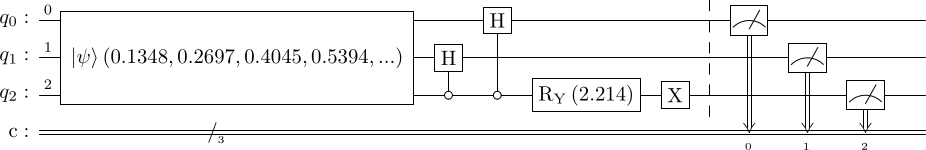

Amplitud Compleja: (1-1.9849549557751675e-16j)
Parte real de la amplitud: 1.000000
Suma Parcial obtenida de manera cuantica 16.583124
Suma Parcial esperada 15.000000


In [34]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
import numpy as np

original_vector = [1, 2, 3, 4 ,5]
num_elements = len(original_vector) # Esto sera nuestra M

# Determina el número de qubits necesarios para representar el vector de entrada
num_qubits = int(np.ceil(np.log2(num_elements)))
total_amplitudes = 2**num_qubits

# Crea el vector de amplitudes y rellenando con ceros por la derecha
amplitudes_base = np.zeros(total_amplitudes)
amplitudes_base[:num_elements] = original_vector

# Normalizamos el vector
norm_l2 = np.linalg.norm(amplitudes_base)
desired_amplitudes = amplitudes_base / norm_l2

# Creamos el circuito, el registro cauntico e inicializamos el estado de entrada o
q_reg = QuantumRegister(num_qubits, name='q')
c_reg = ClassicalRegister(num_qubits, name='c')    
circuit = QuantumCircuit(q_reg, c_reg)

circuit.initialize(desired_amplitudes, q_reg)

# Aplicamos el cirucito del algoritmo 1 hecho en el codeblock anterior
appendee = partial_sums(num_elements, num_qubits)
total_circuit = circuit.compose(appendee)

# Aplicamos la puerta de medicion
total_circuit.barrier()
total_circuit.measure(q_reg, c_reg)

print(f"--- Circuito total del ejemplo practico ---")
display(total_circuit.draw(output='latex', fold=-1))

# Simulamos el circuito
simulator = Aer.get_backend('qasm_simulator')
# Se transpila el circuito para el simulador para que no tenga problemas con ctrl_state='0' 
compiled_circuit = transpile(total_circuit, simulator)

# Guardramos el statevector
compiled_circuit.save_statevector()
job = simulator.run(compiled_circuit).result()
final_statevector = job.get_statevector() 

amplitud_compleja = final_statevector.data[0]
print(f"Amplitud Compleja: {amplitud_compleja}")
amplitud_real = amplitud_compleja.real
print(f"Parte real de la amplitud: {amplitud_real:.6f}")

# sum_{k=0}^{M-1} f_k = f0_tilde_real * sqrt(M)
sum_amplitudes_normalizadas = amplitud_real * np.sqrt(num_elements)
# desnormalizamos
suma_amplitudes_desnormalizadas = sum_amplitudes_normalizadas * norm_l2

print(f"Suma Parcial obtenida de manera cuantica {suma_amplitudes_desnormalizadas:.6f}")

print(f"Suma Parcial esperada {sum(original_vector):.6f}")


Ejemplo con un vector menos trivial $v_{orig} = [1.2, \ 4, \ 5, \ 3.13, \ 1, \ 1, \ 4.444, \ 1, \ 5.69, \ 3, \ 12.5, \ 13.2, \ 19.2]$

Cabe observar que si se quita la medicion la simulacion muestra el valor exacto de la suma parcial.

--- Circuito total del ejemplo practico ---


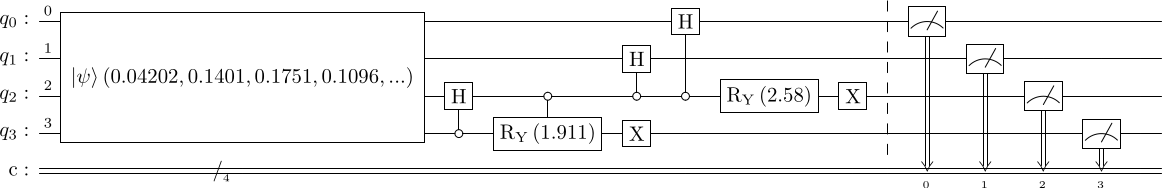

Amplitud Compleja: (1-3.044028368458673e-16j)
Parte real de la amplitud: 1.000000
Suma Parcial obtenida de manera cuantica 102.963089
Suma Parcial esperada 74.364000


In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import Aer
import numpy as np

original_vector = [1.2, 4, 5, 3.13, 1, 1, 4.444, 1, 5.69, 3, 12.5, 13.2, 19.2]
num_elements = len(original_vector) # Esto sera nuestra M

# Determina el número de qubits necesarios para representar el vector de entrada
num_qubits = int(np.ceil(np.log2(num_elements)))
total_amplitudes = 2**num_qubits

# Crea el vector de amplitudes y rellenando con ceros por la derecha
amplitudes_base = np.zeros(total_amplitudes)
amplitudes_base[:num_elements] = original_vector

# Normalizamos el vector
norm_l2 = np.linalg.norm(amplitudes_base)
desired_amplitudes = amplitudes_base / norm_l2

# Creamos el circuito, el registro cuantico e inicializamos el estado de entrada o
q_reg = QuantumRegister(num_qubits, name='q')
c_reg = ClassicalRegister(num_qubits, name='c')    
circuit = QuantumCircuit(q_reg, c_reg)

circuit.initialize(desired_amplitudes, q_reg)

# Aplicamos el cirucito del algoritmo 1 hecho en el codeblock anterior
appendee = partial_sums(num_elements, num_qubits)
total_circuit = circuit.compose(appendee)

total_circuit.barrier()
total_circuit.measure(q_reg, c_reg)

print(f"--- Circuito total del ejemplo practico ---")
display(total_circuit.draw(output='latex', fold=-1))

# Simulamos el circuito
simulator = Aer.get_backend('qasm_simulator')
# Se transpila el circuito para el simulador para que no tenga problemas con ctrl_state='0' 
compiled_circuit = transpile(total_circuit, simulator)

# Guardramos el statevector
compiled_circuit.save_statevector()
job = simulator.run(compiled_circuit).result()
final_statevector = job.get_statevector() 

amplitud_compleja = final_statevector.data[0]
print(f"Amplitud Compleja: {amplitud_compleja}")
amplitud_real = amplitud_compleja.real
print(f"Parte real de la amplitud: {amplitud_real:.6f}")

# sum_{k=0}^{M-1} f_k = f0_tilde_real * sqrt(M)
sum_amplitudes_normalizadas = amplitud_real * np.sqrt(num_elements)
# desnormalizamos
suma_amplitudes_desnormalizadas = sum_amplitudes_normalizadas * norm_l2

print(f"Suma Parcial obtenida de manera cuantica {suma_amplitudes_desnormalizadas:.6f}")
print(f"Suma Parcial esperada {sum(original_vector):.6f}")

Implementacion de calculo de sumas parciales para $\int_{-1}^{1} e^2 dx$

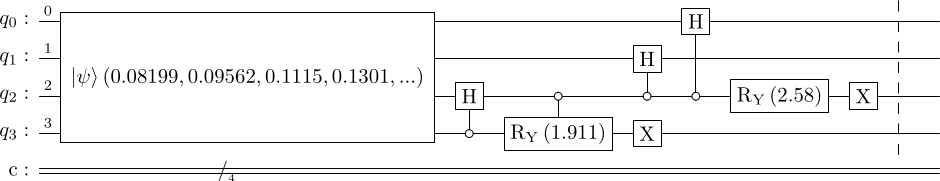

Integral aproximada de manera cuantica: 2.348086
Valor analítico de la integral: 2.350402


In [ ]:
# Define la funcion a integrar y los limites de integracion
def funcion_a_integrar(x):
    return np.exp(x)
a = -1.0
b = 1.0

# Calcula el numero de puntos de muestreo y el ancho del intervalo
num_muestreos = 13
ancho_intervalo = (b - a) / num_muestreos
# Genera los puntos de muestreo (puntos medios de cada intervalo)
puntos_muestreo = a + (np.arange(num_muestreos) + 0.5) * ancho_intervalo

# Calcula los valores de la función en los puntos de muestreo
vector_valores = funcion_a_integrar(puntos_muestreo)

# Numero de qubits y el tamaño total del vector de estado cuántico
num_qubits = int(np.ceil(np.log2(num_muestreos)))
num_amplitudes = 2**num_qubits

# Crea el vector de amplitudes y rellenando con ceros por la derecha
amplitudes_base_para_estado = np.zeros(num_amplitudes, dtype=float)
amplitudes_base_para_estado[:num_muestreos] = vector_valores

# Normalizacion del vector
norma_l2 = np.linalg.norm(amplitudes_base_para_estado)
amplitudes_normalizadas_para_qiskit = amplitudes_base_para_estado / norma_l2

# Crea circuito, registro y lo inicializa
q_reg = QuantumRegister(num_qubits, name='q')
c_reg = ClassicalRegister(num_qubits, name='c')
circuit = QuantumCircuit(q_reg, c_reg)
circuit.initialize(amplitudes_normalizadas_para_qiskit, q_reg)

# Aplicar el cirucito del algoritmo 1 hecho en el codeblock anterior
appendee = partial_sums(num_muestreos, num_qubits)
total_circuit = circuit.compose(appendee)

total_circuit.barrier()

display(total_circuit.draw(output='latex', fold=-1))

# Simulamos el circuito
simulator = Aer.get_backend('qasm_simulator')
# Se transpila el circuito para el simulador para que no tenga problemas con ctrl_state='0'
compiled_circuit = transpile(total_circuit, simulator)

# Guardramos el statevector
compiled_circuit.save_statevector()
job = simulator.run(compiled_circuit).result()
final_statevector = job.get_statevector()
amplitud_compleja = final_statevector.data[0]
amplitud_real = amplitud_compleja.real

# Sumar las amplitudes y desnormalizar
sum_amplitudes_normalizadas = amplitud_real * np.sqrt(num_muestreos)
suma_amplitudes_desnormalizadas = sum_amplitudes_normalizadas * norma_l2

# Multiplicar por el ancho del intervalo para obtener la integral aproximada
integral_aproximada_cuantica = ancho_intervalo * suma_amplitudes_desnormalizadas
print(f"Integral aproximada de manera cuantica: {integral_aproximada_cuantica:.6f}")

valor_analitico = np.exp(1) - np.exp(-1)
print(f"Valor analítico de la integral: {valor_analitico:.6f}")